## Deprecated
Use `extract_provincial.ipynb` instead.

In [1]:
%load_ext autoreload
import osmnx as ox
import os
from pathlib import Path
from tqdm import tqdm
import warnings
import boto3
from s3_client import S3ClientHandler
from datetime import date
import random 
import geopandas as gpd
import time
import random

In [2]:
client = S3ClientHandler()

Permissions verified for bucket: amenities-dataset


In [ ]:
df = client.list_files_with_sizes()
split_cols = df['file_name'].str.split('/', expand=True)
split_cols.columns = ['folder','snapshot_date', 'file']

import pandas as pd

df = pd.concat([df, split_cols], axis=1)

In [16]:
from matplotlib import pyplot as plt

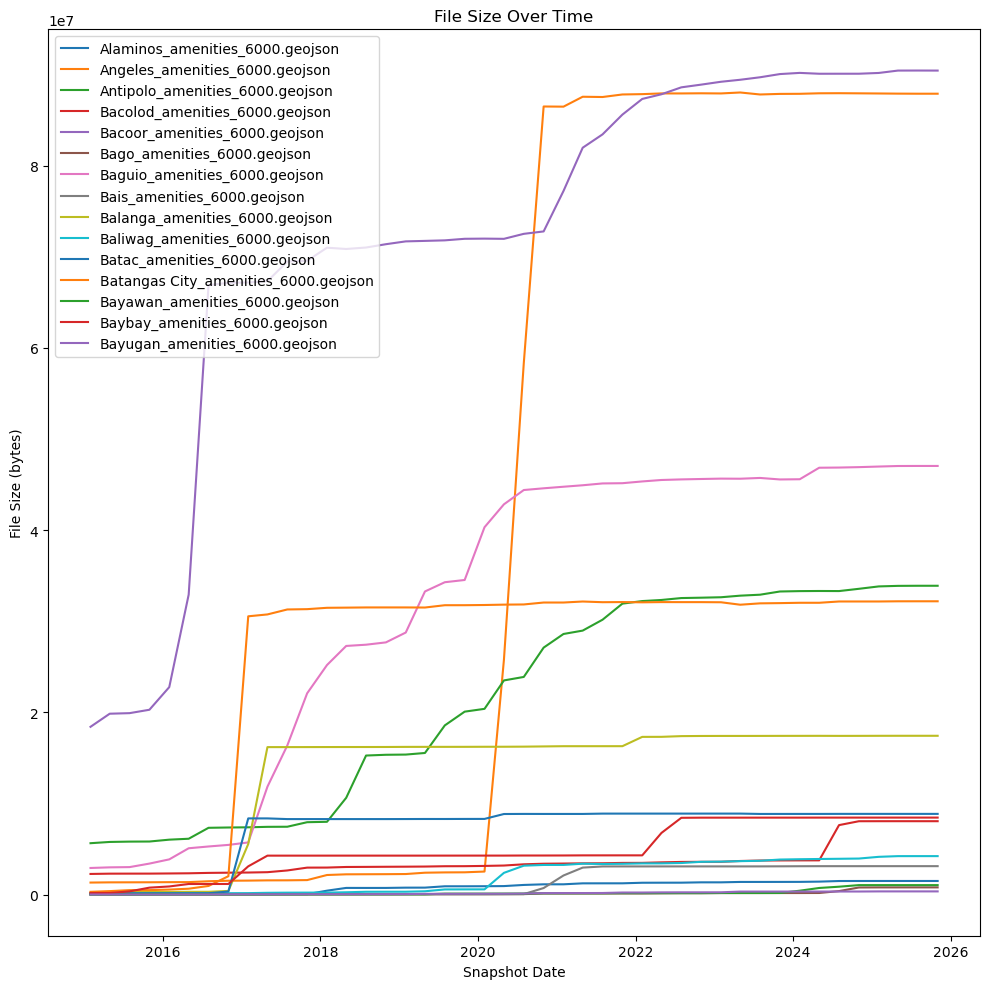

In [38]:
plt.figure(figsize=(10, 10))
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], errors='coerce')
for file in df['file'].unique()[:15]:
    filtered = df[df['file'] == file]
    plt.plot(filtered['snapshot_date'],filtered['size_bytes'], label=file)
    plt.legend()
plt.xlabel('Snapshot Date')
plt.ylabel('File Size (bytes)')
plt.title('File Size Over Time')
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
df

,file_name,size_bytes,folder,snapshot_date,file
0,amenities/2015-02-01T00:00:00Z/Alaminos_amenit...,17989,amenities,2015-02-01 00:00:00+00:00,Alaminos_amenities_6000.geojson
1,amenities/2015-02-01T00:00:00Z/Angeles_ameniti...,1313941,amenities,2015-02-01 00:00:00+00:00,Angeles_amenities_6000.geojson
2,amenities/2015-02-01T00:00:00Z/Antipolo_amenit...,5634450,amenities,2015-02-01 00:00:00+00:00,Antipolo_amenities_6000.geojson
3,amenities/2015-02-01T00:00:00Z/Bacolod_ameniti...,2259344,amenities,2015-02-01 00:00:00+00:00,Bacolod_amenities_6000.geojson
4,amenities/2015-02-01T00:00:00Z/Bacoor_amenitie...,18408086,amenities,2015-02-01 00:00:00+00:00,Bacoor_amenities_6000.geojson
...,...,...,...,...,...
6373,amenities/2025-11-01T00:00:00Z/Valenzuela_amen...,91813978,amenities,2025-11-01 00:00:00+00:00,Valenzuela_amenities_6000.geojson
6374,amenities/2025-11-01T00:00:00Z/Victorias_ameni...,943721,amenities,2025-11-01 00:00:00+00:00,Victorias_amenities_6000.geojson
6375,amenities/2025-11-01T00:00:00Z/Vigan_amenities...,14893062,amenities,2025-11-01 00:00:00+00:00,Vigan_amenities_6000.geojson
6376,amenities/2025-11-01T00:00:00Z/Zamboanga City_...,3046640,amenities,2025-11-01 00:00:00+00:00,Zamboanga City_amenities_6000.geojson


In [6]:
# explode on split
df = df.explode('split')

In [7]:
df

,file_name,size_bytes,split
0,amenities/2015-02-01T00:00:00Z/Alaminos_amenit...,17989,amenities
0,amenities/2015-02-01T00:00:00Z/Alaminos_amenit...,17989,2015-02-01T00:00:00Z
0,amenities/2015-02-01T00:00:00Z/Alaminos_amenit...,17989,Alaminos_amenities_6000.geojson
1,amenities/2015-02-01T00:00:00Z/Angeles_ameniti...,1313941,amenities
1,amenities/2015-02-01T00:00:00Z/Angeles_ameniti...,1313941,2015-02-01T00:00:00Z
...,...,...,...
6376,amenities/2025-11-01T00:00:00Z/Zamboanga City_...,3046640,amenities
6376,amenities/2025-11-01T00:00:00Z/Zamboanga City_...,3046640,2025-11-01T00:00:00Z
6376,amenities/2025-11-01T00:00:00Z/Zamboanga City_...,3046640,Zamboanga City_amenities_6000.geojson
6377,amenities/cities_gdf.geojson,1426752,amenities


In [3]:
# FOR JOJIE
# CACHE_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/cache')
# LOGS_DIR = Path('/mnt/processed/private/msds2025/cpt3/publication/logs')

# For cache
CACHE_DIR = Path('./cache')
LOGS_DIR = Path('./logs')

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

In [4]:
# OSMNX Settings
ox.settings.use_cache = True
ox.settings.log_console = True
ox.settings.cache_folder = CACHE_DIR
ox.settings.data_folder = None # Change to S3
ox.settings.logs_folder = LOGS_DIR
ox.settings.log_file = True

ox.settings.default_crs = "epsg:4326"
ox.settings.requests_timeout = 1000
ox.settings.max_query_area_size = 2500000000

AMENITY_RADIUS = 6000

## Get List of Cities

In [5]:
if not client.check_geodataframe_exists("cities_gdf"):
    ox.settings.max_query_area_size = 25000000000 # Temporarily increase the max query area size to 250 million square meters
    cities_gdf = ox.features.features_from_place("Philippines", tags={"place": "city"})
    ox.settings.max_query_area_size = 2500000000
    client.upload_geodataframe(cities_gdf, "cities_gdf")
else:
    print("Loading cities_gdf from S3")
    cities_gdf = client.get_geodataframe("cities_gdf")
    display(cities_gdf.head())

Loading cities_gdf from S3


/opt/anaconda3/envs/ox/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 198498476 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


,element,id,admin_level,admin_type:PH,capital,name,name:ar,name:az-Arab,name:azb,name:de,...,founding_legislation,contact:facebook,contact:twitter,name:zh-Hant-HK,type,boundary,check_date,source:geometry,border_type,geometry
0,node,14446670,6,highly_urbanized_city,None,Quezon City,مدينة كيزون,None,None,Quezon City,...,None,None,None,None,None,None,NaT,None,None,POINT (121.04863 14.65105)
1,node,25653778,6,None,3,Legazpi,None,None,None,None,...,None,None,None,None,None,None,NaT,None,None,POINT (123.73457 13.13885)
2,node,27170104,6,None,None,Angeles,آنخلس,آنخلس,آنخلس,None,...,None,None,None,None,None,None,NaT,None,None,POINT (120.58753 15.13894)
3,node,27175814,6,None,None,Olongapo,أولونجابو,None,None,None,...,None,None,None,None,None,None,NaT,None,None,POINT (120.28352 14.83147)
4,node,30917625,6,None,None,Urdaneta,None,None,None,None,...,None,None,None,None,None,None,NaT,None,None,POINT (120.5669 15.976)


## Get City Features

In [7]:
FEATURES_TO_RETAIN = ['building','amenity','leisure','public_transport','office','shop','tourism','name','geometry']
tags = {"building": True, "amenity": True, "leasure": True, "public_transport": True, "office": True, "shop": True, "tourism": True, }

In [8]:
snapshot_dates = [
    date(year, month, 1)
    for year in range(2025, 2014, -1)
    for month in (2, 5, 8, 11)  # February, May, August, November
]

print("Snapshot dates:")
for snapshot_date in snapshot_dates:
    print(snapshot_date.strftime("%Y-%m-%d"))

Snapshot dates:
2025-02-01
2025-05-01
2025-08-01
2025-11-01
2024-02-01
2024-05-01
2024-08-01
2024-11-01
2023-02-01
2023-05-01
2023-08-01
2023-11-01
2022-02-01
2022-05-01
2022-08-01
2022-11-01
2021-02-01
2021-05-01
2021-08-01
2021-11-01
2020-02-01
2020-05-01
2020-08-01
2020-11-01
2019-02-01
2019-05-01
2019-08-01
2019-11-01
2018-02-01
2018-05-01
2018-08-01
2018-11-01
2017-02-01
2017-05-01
2017-08-01
2017-11-01
2016-02-01
2016-05-01
2016-08-01
2016-11-01
2015-02-01
2015-05-01
2015-08-01
2015-11-01


In [12]:
filename = ''
def crawl(cities_gdf: gpd.GeoDataFrame):
    random.shuffle(snapshot_dates)
    for snapshot_date in snapshot_dates.copy():
        snapshot__str = snapshot_date.strftime("%Y-%m-%dT%H:%M:%SZ")
        print(snapshot__str)
        ox.settings.overpass_settings = f'[out:json][timeout:{{timeout}}][date:"{snapshot__str}"]{{maxsize}}'
        print(ox.settings.overpass_settings)

        cities_gdf = cities_gdf.sample(frac=1)

        for idx, row in (pbar := tqdm(cities_gdf.iterrows(), total=len(cities_gdf), desc="Processing cities")):
            city_name = row['name']
            global filename
            filename = f"{snapshot__str}/{city_name}_amenities_{AMENITY_RADIUS}"
    
            if client.check_geodataframe_exists(filename):
                # print(f"File {filename} already exists. Skipping...")
                gdf = client.get_geodataframe(filename)

                display(gdf)

                raise Exception("Debugging")
                continue
            pbar.set_description(f"Processing {city_name}")

            address = f"{city_name}, Philippines"
            gdf = ox.features.features_from_address(address=address, tags=tags, dist=AMENITY_RADIUS)
            
        
            existing_columns = [col for col in FEATURES_TO_RETAIN if col in gdf.columns]
            gdf = gdf[existing_columns]
            gdf['city'] = city_name

            
            raise Exception("Debugging")
            pbar.set_description(f"Saving {city_name} - {len(gdf)} features")

            client.upload_geodataframe(gdf, filename)

        # remove the snapshot date from the list
        snapshot_dates.remove(snapshot_date)

while True:
    try:
        crawl(cities_gdf)
        break
    except Exception as e:
        # raise e
        print(f"Error: {e}")
        print("Retrying in 5 seconds...")
        time.sleep(5)

2022-08-01T00:00:00Z
[out:json][timeout:{timeout}][date:"2022-08-01T00:00:00Z"]{maxsize}


Processing cities:   0%|          | 0/163 [00:00<?, ?it/s]

,element,id,building,amenity,leisure,public_transport,office,shop,tourism,name,city,geometry
0,node,27582804,None,fuel,None,None,None,None,None,UniOil,Dasmariñas,POINT (120.98051 14.37227)
1,node,28997041,None,None,None,stop_position,None,None,None,None,Dasmariñas,POINT (120.98446 14.3405)
2,node,28997085,None,None,None,stop_position,None,None,None,None,Dasmariñas,POINT (120.98418 14.34086)
3,node,255061268,None,pub,None,None,None,None,None,Seareyna,Dasmariñas,POINT (120.91527 14.31533)
4,node,255064820,None,None,None,None,None,pastry,None,Red Ribbon,Dasmariñas,POINT (120.9407 14.32615)
...,...,...,...,...,...,...,...,...,...,...,...,...
183138,way,1081805308,residential,None,None,None,None,None,None,None,Dasmariñas,"POLYGON ((120.94681 14.30503, 120.94686 14.305..."
183139,way,1081805309,residential,None,None,None,None,None,None,None,Dasmariñas,"POLYGON ((120.94689 14.30507, 120.94695 14.305..."
183140,way,1081811174,roof,None,sports_centre,None,None,None,None,None,Dasmariñas,"POLYGON ((120.948 14.30558, 120.94814 14.30565..."
183141,way,1081811176,yes,None,fitness_centre,None,None,None,None,None,Dasmariñas,"POLYGON ((120.94774 14.30538, 120.94781 14.305..."


Processing cities:   0%|          | 0/163 [00:07<?, ?it/s]


Error: Debugging
Retrying in 5 seconds...


KeyboardInterrupt: 

In [19]:
filename

'2022-08-01T00:00:00Z/Dasmariñas_amenities_6000'

In [13]:
gdf = client.get_geodataframe(filename)

display(gdf)

,element,id,building,amenity,leisure,public_transport,office,shop,tourism,name,city,geometry
0,node,27582804,None,fuel,None,None,None,None,None,UniOil,Dasmariñas,POINT (120.98051 14.37227)
1,node,28997041,None,None,None,stop_position,None,None,None,None,Dasmariñas,POINT (120.98446 14.3405)
2,node,28997085,None,None,None,stop_position,None,None,None,None,Dasmariñas,POINT (120.98418 14.34086)
3,node,255061268,None,pub,None,None,None,None,None,Seareyna,Dasmariñas,POINT (120.91527 14.31533)
4,node,255064820,None,None,None,None,None,pastry,None,Red Ribbon,Dasmariñas,POINT (120.9407 14.32615)
...,...,...,...,...,...,...,...,...,...,...,...,...
183138,way,1081805308,residential,None,None,None,None,None,None,None,Dasmariñas,"POLYGON ((120.94681 14.30503, 120.94686 14.305..."
183139,way,1081805309,residential,None,None,None,None,None,None,None,Dasmariñas,"POLYGON ((120.94689 14.30507, 120.94695 14.305..."
183140,way,1081811174,roof,None,sports_centre,None,None,None,None,None,Dasmariñas,"POLYGON ((120.948 14.30558, 120.94814 14.30565..."
183141,way,1081811176,yes,None,fitness_centre,None,None,None,None,None,Dasmariñas,"POLYGON ((120.94774 14.30538, 120.94781 14.305..."


In [18]:
gdf['geometry']

0                                POINT (120.98051 14.37227)
1                                 POINT (120.98446 14.3405)
2                                POINT (120.98418 14.34086)
3                                POINT (120.91527 14.31533)
4                                 POINT (120.9407 14.32615)
                                ...                        
183138    POLYGON ((120.94681 14.30503, 120.94686 14.305...
183139    POLYGON ((120.94689 14.30507, 120.94695 14.305...
183140    POLYGON ((120.948 14.30558, 120.94814 14.30565...
183141    POLYGON ((120.94774 14.30538, 120.94781 14.305...
183142    POLYGON ((120.9479 14.3054, 120.94794 14.30534...
Name: geometry, Length: 183143, dtype: geometry

In [22]:
gdf['area_m2'] = gdf.geometry.area

/var/folders/94/qqxkptrd1bg66t_3104htv1m0000gn/T/ipykernel_97187/2155681892.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['area_m2'] = gdf.geometry.area


In [36]:
gdf.to_file("output_file.geojson", driver="GeoJSON")

In [20]:
gdf.geom_type.value_counts()

Polygon         180826
Point             2224
LineString          72
MultiPolygon        21
Name: count, dtype: int64

In [42]:
gdf.geometry.area

/var/folders/94/qqxkptrd1bg66t_3104htv1m0000gn/T/ipykernel_97187/1689662037.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.geometry.area


0         0.000000e+00
1         0.000000e+00
2         0.000000e+00
3         0.000000e+00
4         0.000000e+00
              ...     
183138    2.702800e-09
183139    2.702800e-09
183140    4.009016e-08
183141    4.241685e-09
183142    3.022260e-09
Length: 183143, dtype: float64

In [ ]:
display(gdf[~gdf['building'].isna()])

,element,id,building,amenity,leisure,public_transport,office,shop,tourism,name,city,geometry,area_m2
58,node,1043100471,house,None,None,None,None,None,None,None,Dasmariñas,POINT (120.95451 14.30613),0.000000e+00
416,node,3595475694,house,None,None,None,None,None,None,None,Dasmariñas,POINT (120.93988 14.2998),0.000000e+00
463,node,3785714407,office,None,None,None,None,None,None,Universal Storefront Services Corporation,Dasmariñas,POINT (120.95836 14.32956),0.000000e+00
470,node,3785810901,house,None,None,None,None,None,None,Wacker Neuson Manila,Dasmariñas,POINT (120.96197 14.32531),0.000000e+00
471,node,3785836018,yes,None,None,None,None,None,None,LMD Builders Incorporated,Dasmariñas,POINT (120.95301 14.34152),0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
183138,way,1081805308,residential,None,None,None,None,None,None,None,Dasmariñas,"POLYGON ((120.94681 14.30503, 120.94686 14.305...",2.702800e-09
183139,way,1081805309,residential,None,None,None,None,None,None,None,Dasmariñas,"POLYGON ((120.94689 14.30507, 120.94695 14.305...",2.702800e-09
183140,way,1081811174,roof,None,sports_centre,None,None,None,None,None,Dasmariñas,"POLYGON ((120.948 14.30558, 120.94814 14.30565...",4.009016e-08
183141,way,1081811176,yes,None,fitness_centre,None,None,None,None,None,Dasmariñas,"POLYGON ((120.94774 14.30538, 120.94781 14.305...",4.241685e-09


In [24]:
gdf_lines = gdf[gdf.geom_type == 'LineString']

In [25]:
gdf_lines

,element,id,building,amenity,leisure,public_transport,office,shop,tourism,name,city,geometry,area_m2
3488,way,148900873,None,None,None,platform,None,None,None,SM Dasmariñas,Dasmariñas,"LINESTRING (120.95635 14.30064, 120.95614 14.3...",0.0
169099,way,542929492,None,None,None,platform,None,None,None,Walter Mart Dasmariñas,Dasmariñas,"LINESTRING (120.94094 14.32528, 120.94093 14.3...",0.0
169100,way,542929500,None,None,None,platform,None,None,None,Walter Mart Dasmariñas,Dasmariñas,"LINESTRING (120.94103 14.32497, 120.94094 14.3...",0.0
169813,way,555237463,None,None,None,platform,None,None,None,Robinsons Place Dasmariñas,Dasmariñas,"LINESTRING (120.95457 14.29952, 120.95456 14.2...",0.0
169836,way,559189872,None,None,None,platform,None,None,None,Kidzworld,Dasmariñas,"LINESTRING (120.95392 14.30429, 120.95389 14.3...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182480,way,1033118587,None,None,None,platform,None,None,None,Sakada,Dasmariñas,"LINESTRING (120.98171 14.34496, 120.98178 14.3...",0.0
182979,way,1073730517,None,None,None,platform,None,None,None,Avida Sta. Cecilia,Dasmariñas,"LINESTRING (120.98773 14.33115, 120.98773 14.3...",0.0
182980,way,1073730518,None,None,None,platform,None,None,None,Avida Sta. Cecilia,Dasmariñas,"LINESTRING (120.98788 14.33076, 120.98792 14.3...",0.0
183064,way,1079776695,None,None,None,platform,None,None,None,None,Dasmariñas,"LINESTRING (120.95791 14.30004, 120.95775 14.3...",0.0
